In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'D:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
covid=cv2.imread("C:\\Users\\Lenovo\\OneDrive\\Desktop\\ML_lab\\ct_scan\\COVID")
covid

In [4]:
non_covid=cv2.imread("C:\\Users\\Lenovo\\OneDrive\\Desktop\\ML_lab\\ct_scan\\non-COVID")
non_covid

In [5]:
disease_types=['COVID', 'non-COVID']
data_dir = 'C:\\Users\\Lenovo\\OneDrive\\Desktop\\ML_lab\\ct_scan'
train_dir = os.path.join(data_dir)

In [6]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID


In [7]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1227).png,0,COVID
1,COVID/Covid (430).png,0,COVID
2,non-COVID/Non-Covid (322).png,1,non-COVID
3,non-COVID/Non-Covid (379).png,1,non-COVID
4,COVID/Covid (609).png,0,COVID


In [8]:
pip install pandas-profiling[notebook]

  Using cached MarkupSafe-2.1.1-cp38-cp38-win_amd64.whl (17 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Anaconda\\Lib\\site-packages\\~~rkupsafe\\_speedups.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'D:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [9]:
pip install markupsafe==2.0.1

  Using cached MarkupSafe-2.0.1-cp38-cp38-win_amd64.whl (14 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
sphinx 4.0.1 requires MarkupSafe<2.0, but you have markupsafe 2.0.1 which is incompatible.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
You should consider upgrading via the 'D:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [10]:
import pandas_profiling as pp
pp.ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

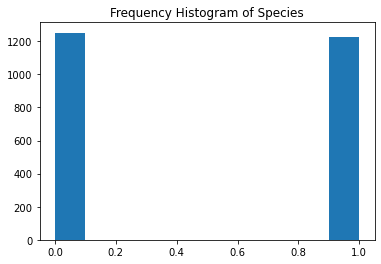

<Figure size 864x864 with 0 Axes>

In [11]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

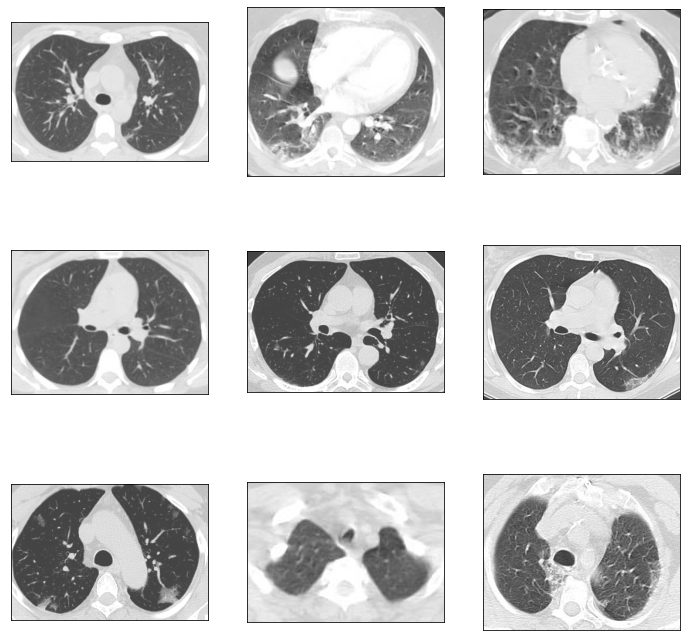

In [12]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 3, 3)

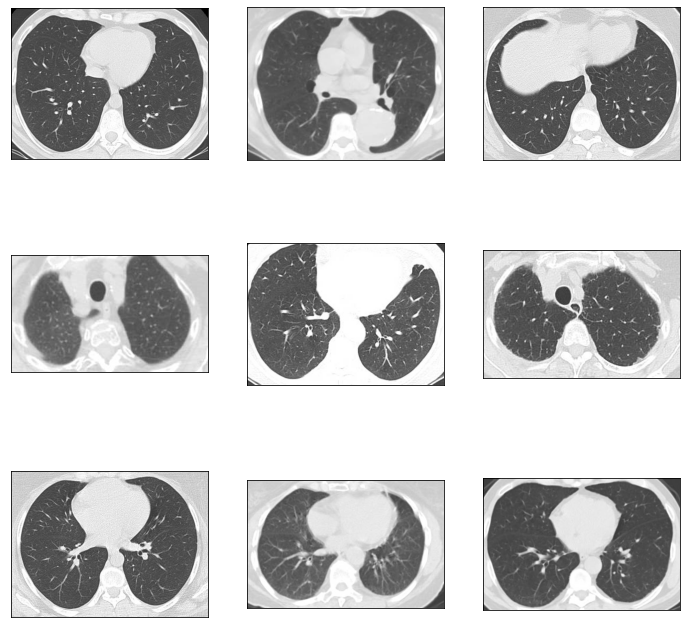

In [13]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 3, 3)

In [14]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [15]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:21, 117.22it/s]


Train Shape: (2481, 64, 64, 3)


In [16]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2481, 2)


In [17]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [18]:
X_train

array([[[[0.76470588, 0.76470588, 0.76470588],
         [0.80392157, 0.80392157, 0.80392157],
         [0.8745098 , 0.8745098 , 0.8745098 ],
         ...,
         [0.75686275, 0.75686275, 0.75686275],
         [0.76078431, 0.76078431, 0.76078431],
         [0.76470588, 0.76470588, 0.76470588]],

        [[0.78431373, 0.78431373, 0.78431373],
         [0.86666667, 0.86666667, 0.86666667],
         [0.86666667, 0.86666667, 0.86666667],
         ...,
         [0.76078431, 0.76078431, 0.76078431],
         [0.76078431, 0.76078431, 0.76078431],
         [0.75686275, 0.75686275, 0.75686275]],

        [[0.83921569, 0.83921569, 0.83921569],
         [0.86666667, 0.86666667, 0.86666667],
         [0.87058824, 0.87058824, 0.87058824],
         ...,
         [0.76078431, 0.76078431, 0.76078431],
         [0.75686275, 0.75686275, 0.75686275],
         [0.76470588, 0.76470588, 0.76470588]],

        ...,

        [[0.89411765, 0.89411765, 0.89411765],
         [0.88235294, 0.88235294, 0.88235294]

In [19]:
X_val

array([[[[0.21960784, 0.21960784, 0.21960784],
         [0.23529412, 0.23529412, 0.23529412],
         [0.55294118, 0.55294118, 0.55294118],
         ...,
         [0.74117647, 0.74117647, 0.74117647],
         [0.2627451 , 0.2627451 , 0.2627451 ],
         [0.22745098, 0.22745098, 0.22745098]],

        [[0.22352941, 0.22352941, 0.22352941],
         [0.43921569, 0.43921569, 0.43921569],
         [0.81568627, 0.81568627, 0.81568627],
         ...,
         [0.80784314, 0.80784314, 0.80784314],
         [0.57647059, 0.57647059, 0.57647059],
         [0.22352941, 0.22352941, 0.22352941]],

        [[0.29803922, 0.29803922, 0.29803922],
         [0.77254902, 0.77254902, 0.77254902],
         [0.78039216, 0.78039216, 0.78039216],
         ...,
         [0.78039216, 0.78039216, 0.78039216],
         [0.81568627, 0.81568627, 0.81568627],
         [0.38039216, 0.38039216, 0.38039216]],

        ...,

        [[0.81568627, 0.81568627, 0.81568627],
         [0.81568627, 0.81568627, 0.81568627]

In [20]:
Y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [21]:
Y_val

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.

In [22]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1984, 64, 64, 3)
X_val: (497, 64, 64, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


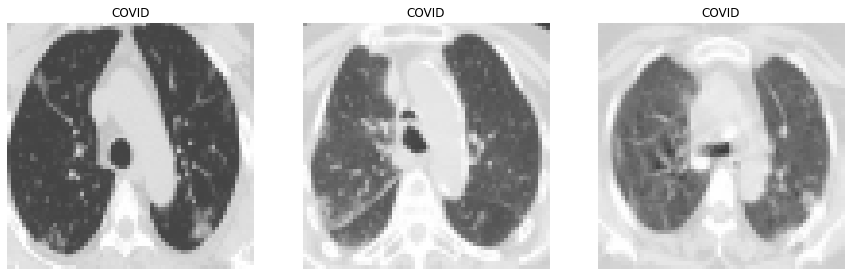

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [24]:
EPOCHS = 50
SIZE=64
N_ch=3

In [25]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [26]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0     

D:\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'D:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [28]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'D:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [29]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'D:\Anaconda\python.exe -m pip install --upgrade pip' command.


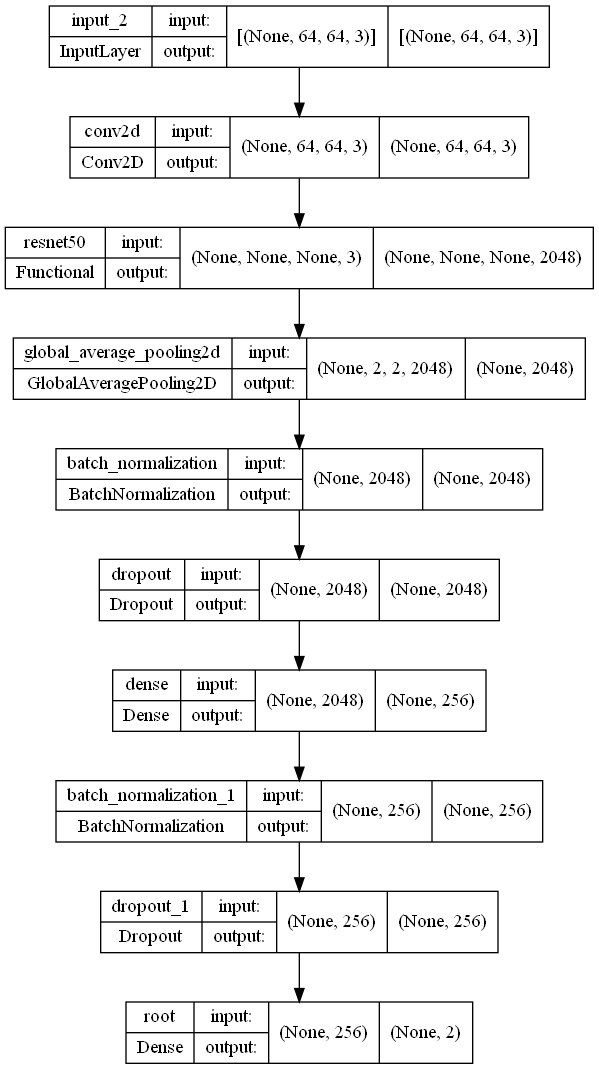

In [30]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [31]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))



<ipython-input-31-2fe7264ebb57>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.2109 - accuracy: 0.5333
Epoch 1: val_loss improved from inf to 2.91680, saving model to model.h5
31/31 [==============================] - 70s 2s/step - loss: 1.2109 - accuracy: 0.5333 - val_loss: 2.9168 - val_accuracy: 0.5513 - lr: 0.0030
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.9418 - accuracy: 0.6094
Epoch 2: val_loss improved from 2.91680 to 1.14899, saving model to model.h5
31/31 [==============================] - 65s 2s/step - loss: 0.9418 - accuracy: 0.6094 - val_loss: 1.1490 - val_accuracy: 0.4487 - lr: 0.0030
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.8577 - accuracy: 0.6346
Epoch 3: val_loss did not improve from 1.14899
31/31 [==============================] - 70s 2s/step - loss: 0.8577 - accuracy: 0.6346 - val_loss: 1.3091 - val_accuracy: 0.5513 - lr: 0.0030
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.6542
E

Epoch 28/50
31/31 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8473
Epoch 28: val_loss did not improve from 0.50367
31/31 [==============================] - 66s 2s/step - loss: 0.3719 - accuracy: 0.8473 - val_loss: 0.5152 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 29/50
31/31 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8372
Epoch 29: val_loss improved from 0.50367 to 0.48787, saving model to model.h5
31/31 [==============================] - 78s 2s/step - loss: 0.3759 - accuracy: 0.8372 - val_loss: 0.4879 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.8397
Epoch 30: val_loss did not improve from 0.48787
31/31 [==============================] - 83s 3s/step - loss: 0.3690 - accuracy: 0.8397 - val_loss: 0.5287 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.8407
Epoch 31: val_loss i

In [32]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 2s 136ms/step - loss: 0.3661 - accuracy: 0.8451
Final Loss: 0.36610129475593567, Final Accuracy: 0.8450704216957092


Text(0.5, 145.31999999999996, 'Predicted')

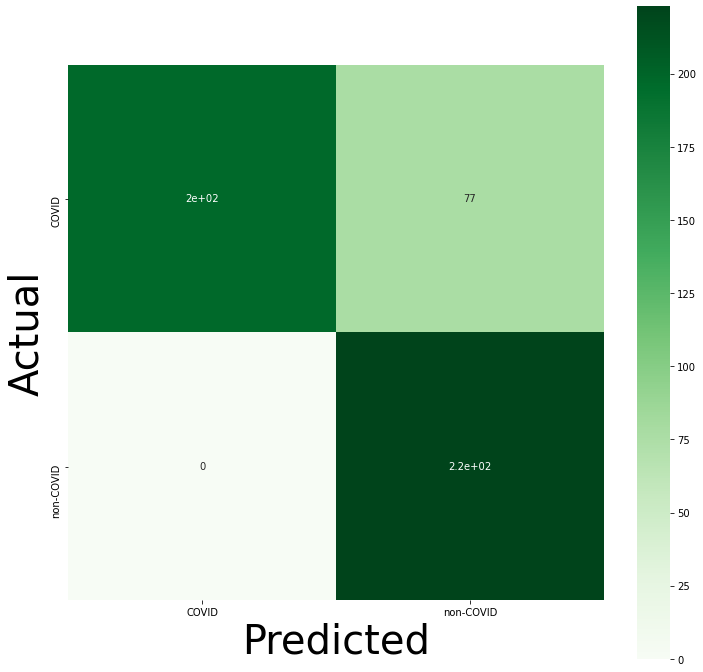

In [33]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

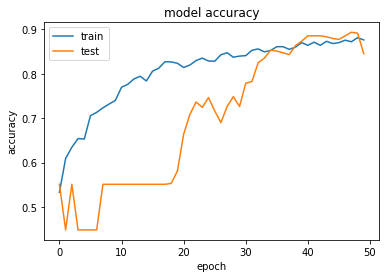

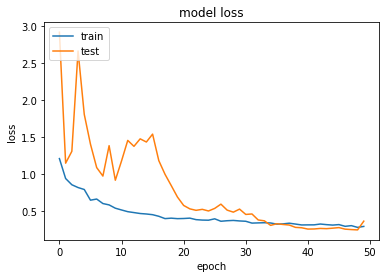

In [34]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


[0.99467707 0.00532295]


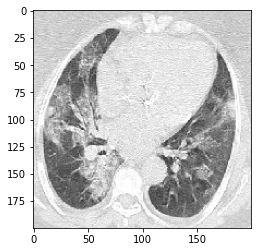

Prediction: Covid-19


In [35]:
from skimage import io
from keras.preprocessing import image
img = image.load_img("C:\\Users\\Lenovo\\OneDrive\\Desktop\\ML_lab\\ct_scan\\COVID\\Covid (1014).png", grayscale=False, target_size=(64, 64))
show_img=image.load_img("C:\\Users\\Lenovo\\OneDrive\\Desktop\\ML_lab\\ct_scan\\COVID\\Covid (1014).png", grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

[0.16120134 0.83879864]


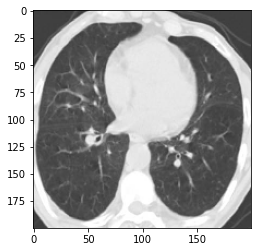

Prediction: Non Covid-19


In [36]:
from skimage import io
from keras.preprocessing import image
img = image.load_img("C:\\Users\\Lenovo\\OneDrive\\Desktop\\ML_lab\\ct_scan\\non-COVID\\Non-Covid (14).png", grayscale=False, target_size=(64, 64))
show_img=image.load_img("C:\\Users\\Lenovo\\OneDrive\\Desktop\\ML_lab\\ct_scan\\non-COVID\\Non-Covid (14).png", grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])